In [26]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from parameters import *
from static import *
from data_frame import *
from helper import *
import calmap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data_frame('../data/GSPC.csv', reference_date, current_date, moveback_date).df

,Date,Open,High,Low,Close,Adj Close,Volume,Noramlized_Close,Diff,Pct_Diff,Normalized_Diff
Date,,,,,,,,,,,
2019-07-23,2019-07-23,2994.739990,3005.899902,2988.560059,3005.469971,3005.469971,3313660000,1.259558,20.439942,0.006847,0.008566
2019-07-24,2019-07-24,2998.770020,3019.590088,2996.820068,3019.560059,3019.560059,3428980000,1.265463,14.090088,0.004688,0.005905
2019-07-25,2019-07-25,3016.260010,3016.310059,2997.239990,3003.669922,3003.669922,3645270000,1.258804,-15.890137,-0.005262,-0.006659
2019-07-26,2019-07-26,3013.250000,3027.979980,3012.590088,3025.860107,3025.860107,3257590000,1.268104,22.190185,0.007388,0.009300
2019-07-29,2019-07-29,3024.469971,3025.610107,3014.300049,3020.969971,3020.969971,3203710000,1.266054,-4.890136,-0.001616,-0.002049
...,...,...,...,...,...,...,...,...,...,...,...
2020-07-16,2020-07-16,3208.360107,3220.389893,3198.590088,3215.570068,3215.570068,3961230000,1.347609,-10.989991,-0.003406,-0.004606
2020-07-17,2020-07-17,3224.209961,3233.520020,3205.649902,3224.729980,3224.729980,3993830000,1.351448,9.159912,0.002849,0.003839
2020-07-20,2020-07-20,3224.290039,3258.610107,3215.159912,3251.840088,3251.840088,3971200000,1.362809,27.110108,0.008407,0.011362


In [28]:
bayesian_count(filepaths)

{'Splunk': {'before': {'positive': 0.5333333333333333,
   'negative': 0.4666666666666667,
   'count': 105},
  'after': {'positive': 0.632183908045977,
   'negative': 0.367816091954023,
   'count': 87}},
 'Datadog': {'before': {'positive': 0.49523809523809526,
   'negative': 0.5047619047619047,
   'count': 105},
  'after': {'positive': 0.6666666666666666,
   'negative': 0.33333333333333337,
   'count': 87}},
 'Dynatrace': {'before': {'positive': 0.5142857142857142,
   'negative': 0.48571428571428577,
   'count': 105},
  'after': {'positive': 0.6206896551724138,
   'negative': 0.3793103448275862,
   'count': 87}},
 'New Relic': {'before': {'positive': 0.4666666666666667,
   'negative': 0.5333333333333333,
   'count': 105},
  'after': {'positive': 0.5517241379310345,
   'negative': 0.4482758620689655,
   'count': 87}}}

In [4]:
data = data_frame('../data/SPLK.csv', reference_date, current_date, moveback_date).df
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Noramlized_Close,Diff,Pct_Diff,Normalized_Diff
Date,,,,,,,,,,,
2019-07-23,2019-07-23,139.080002,139.440002,136.220001,137.770004,137.770004,843700,1.439453,-0.929993,-0.006705,-0.009717
2019-07-24,2019-07-24,137.350006,140.149994,136.630005,139.960007,139.960007,937000,1.462334,2.190003,0.015896,0.022882
2019-07-25,2019-07-25,139.820007,139.889999,137.809998,138.740005,138.740005,1071300,1.449587,-1.220002,-0.008717,-0.012747
2019-07-26,2019-07-26,139.770004,142.059998,139.429993,140.729996,140.729996,1089500,1.470379,1.989991,0.014343,0.020792
2019-07-29,2019-07-29,141.000000,141.360001,134.710007,138.220001,138.220001,976700,1.444154,-2.509995,-0.017836,-0.026225


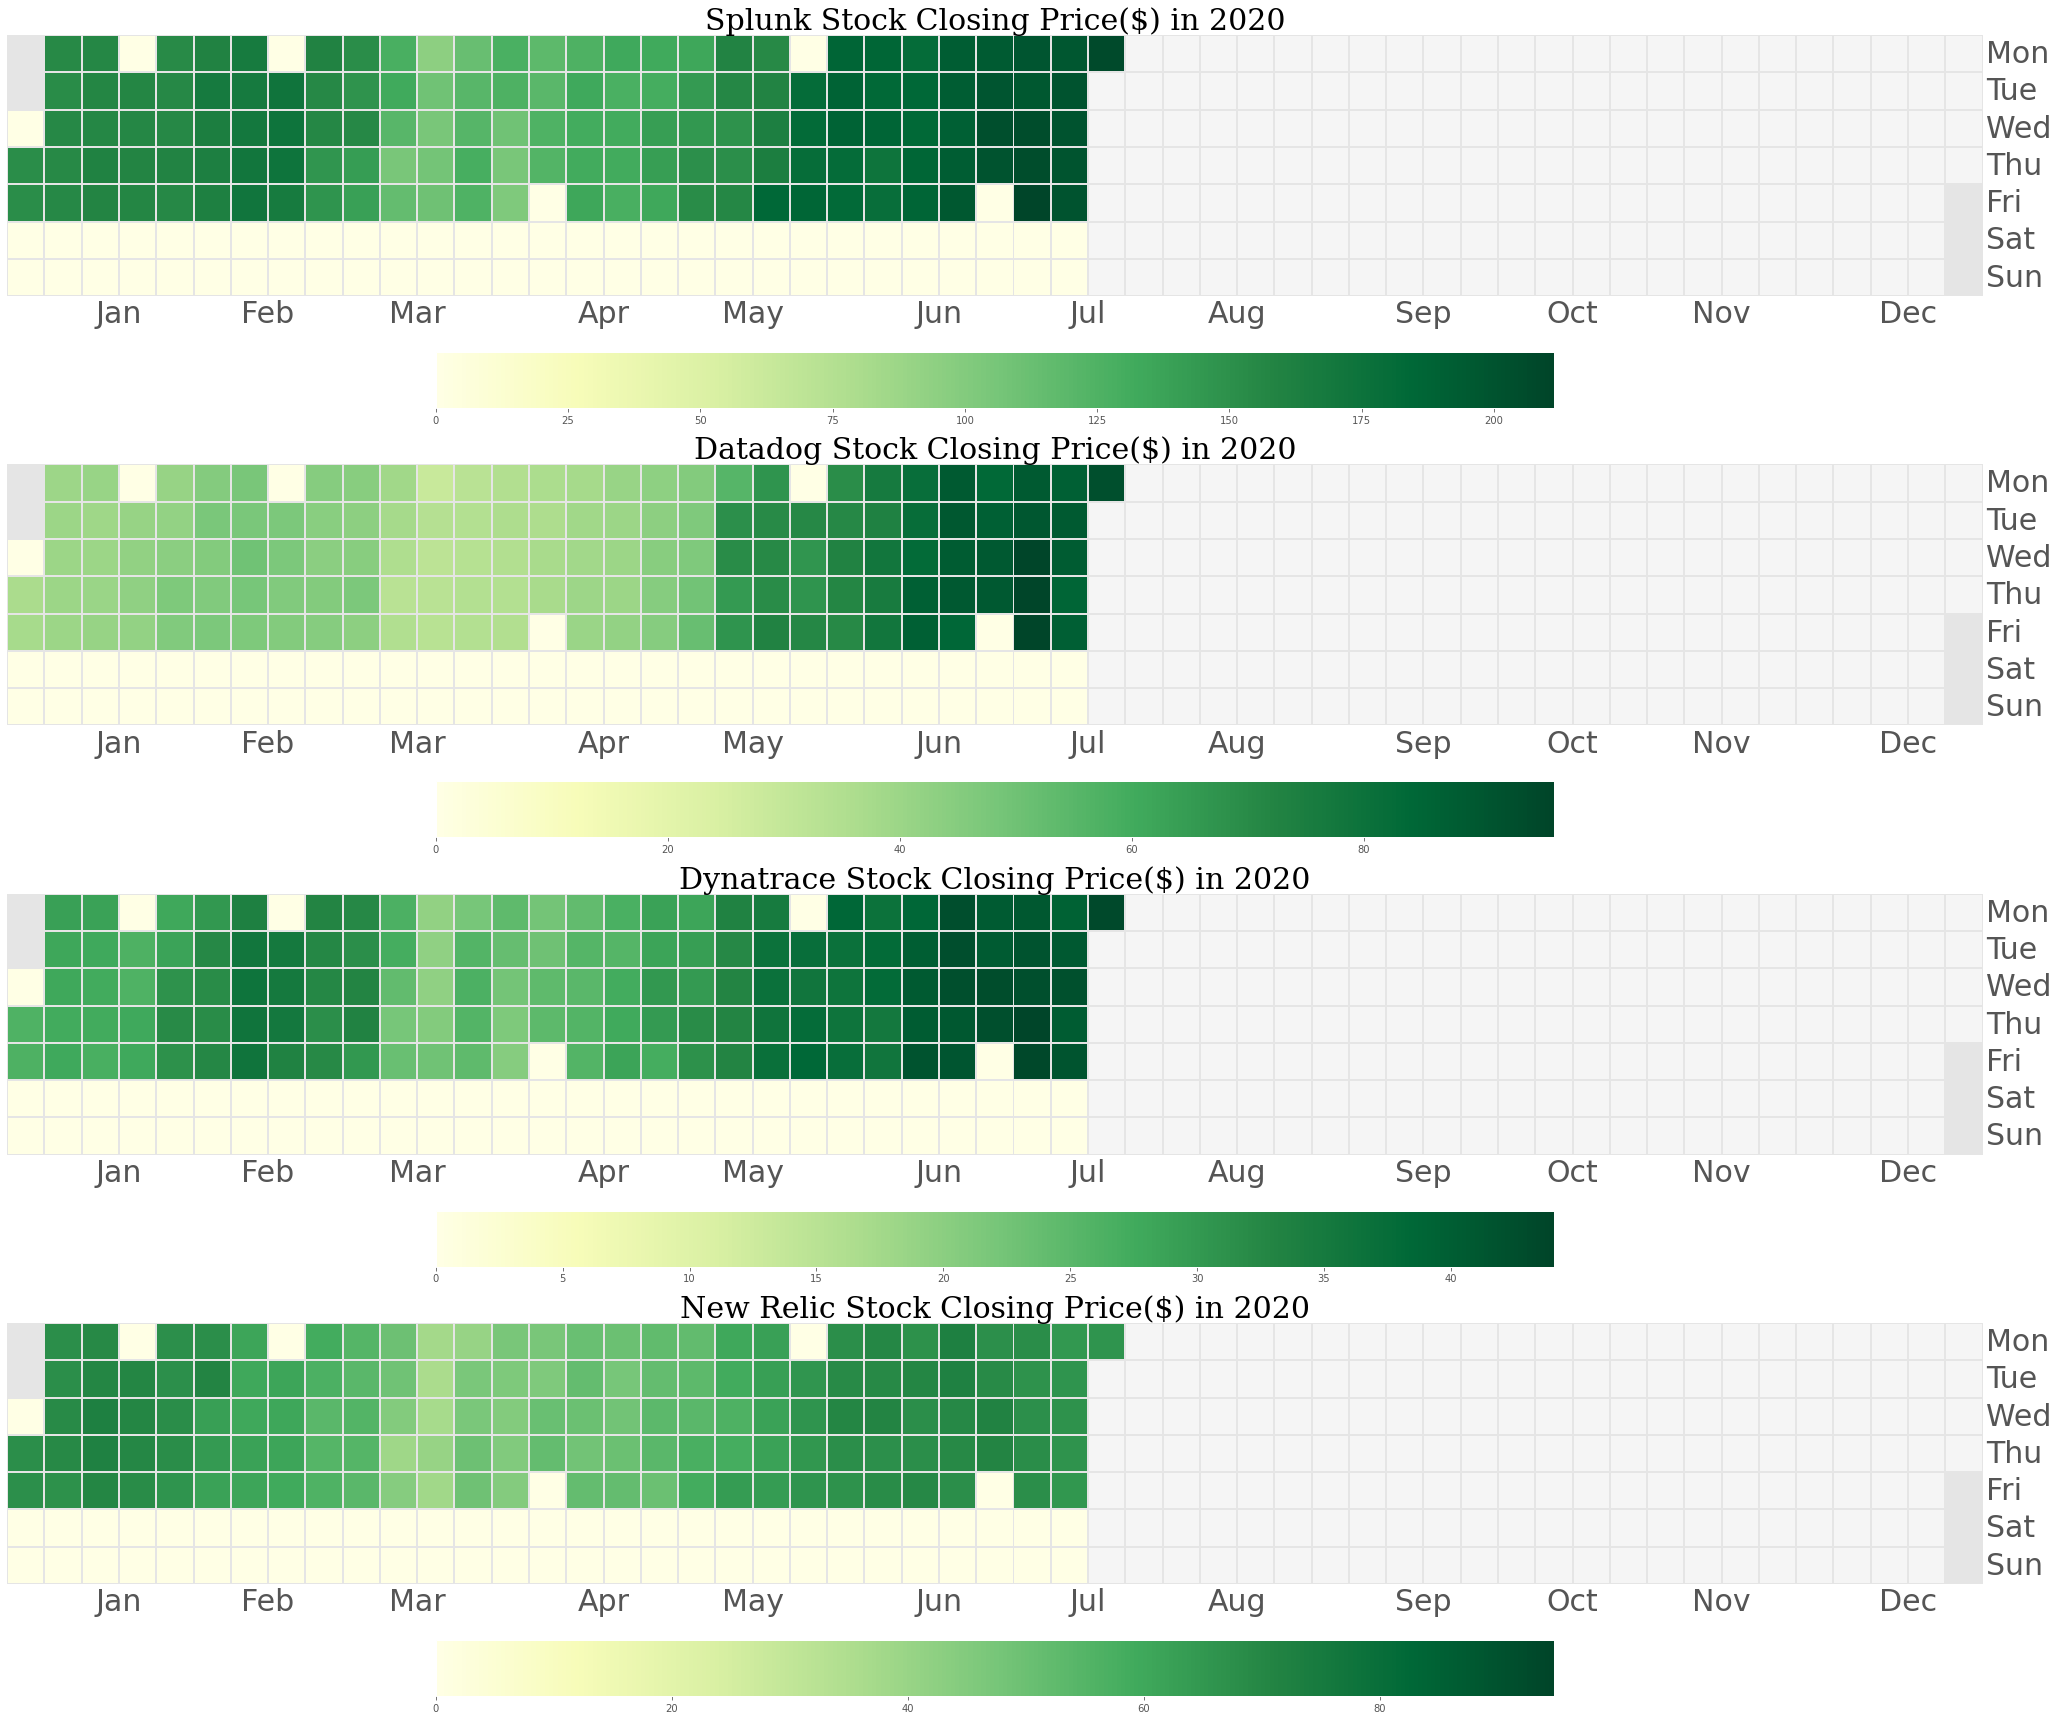

In [6]:
fig, axs = plt.subplots(4, 1, figsize=(30,24))
draw_heatmap(filepaths, fig, axs)    
fig.tight_layout()
# plt.savefig('../figures/heatmap.png')

# Data Visualization

### Baseline

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


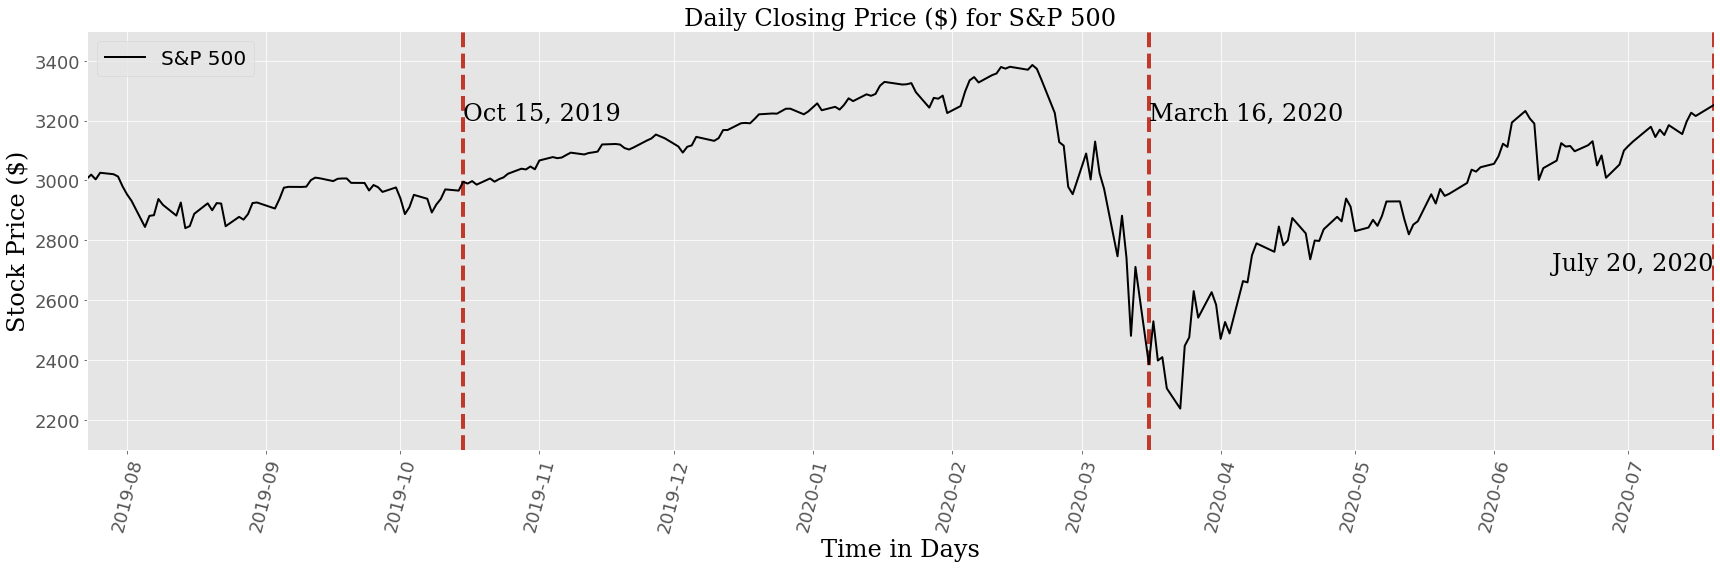

In [7]:
fig, ax = plt.subplots(figsize=(24, 8))
data = data_frame('../data/GSPC.csv', reference_date, current_date, moveback_date)
ax.plot(data.df.index, data.df['Close'], color='k', label='S&P 500', linewidth=2)
ax.legend(loc='upper left', prop={'size': 20})
ax.set_title('Daily Closing Price ($) for S&P 500', fontdict=font)

plot_vlines(ax, [data.reference_date, data.moveback_date, data.current_date], [2100, 3500], ['#C0392B', '#C0392B', '#C0392B'], ['dashed', 'dashed', 'dashed'], [4,4,4])
put_text(ax, [data.moveback_date,data.reference_date,data.current_date], [3200,3200,2700], [r'Oct 15, 2019', r'March 16, 2020', r'July 20, 2020'], [font,font,font], ['left', 'left', 'right'])

ax.xaxis.set_tick_params(rotation=75)
set_axis_sizes(ax)

ax.set_ylim(2100, 3500)
ax.set_xlim(data.start_date, data.current_date)
ax.set_xlabel('Time in Days', fontdict=font)
ax.set_ylabel('Stock Price ($)', fontdict=font)
fig.tight_layout()
plt.savefig('../figures/baseline.png')

### Test Date

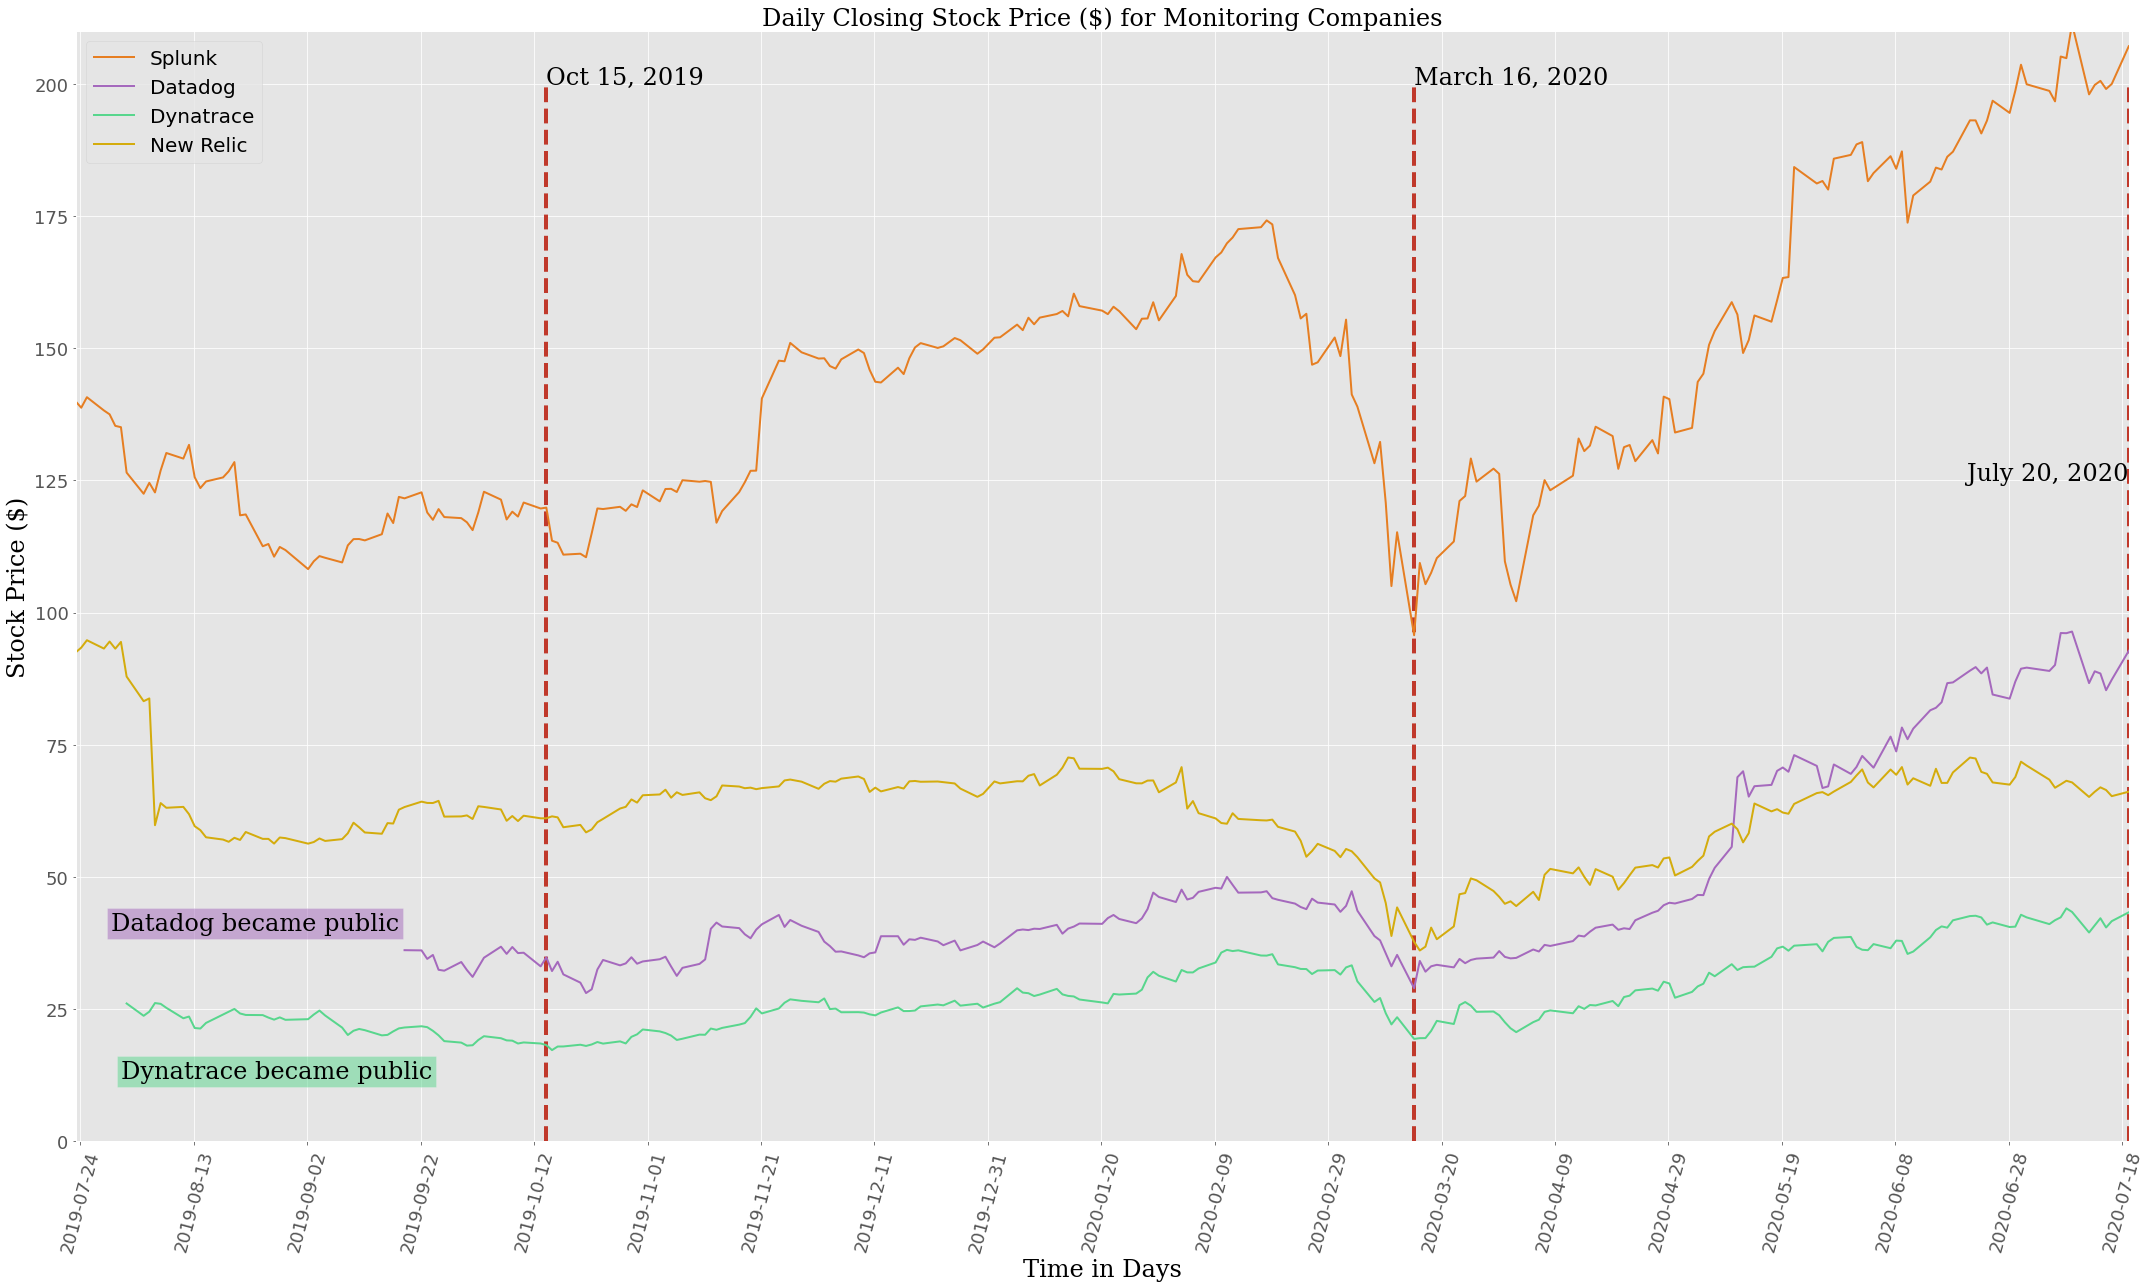

In [10]:
fig, ax = plt.subplots(figsize=(30, 18))

for filepath,color in zip(filepaths, colors):
    data = data_frame(filepath, reference_date, current_date, moveback_date)
    ax.plot(data.df.index, data.df['Close'], color=color, label=refer[filepath], linewidth=2)

plot_vlines(ax, [data.reference_date, data.moveback_date, data.current_date], [0, 200], ['#C0392B', '#C0392B', '#C0392B'], ['dashed', 'dashed', 'dashed'], [4,4,4])
put_text(ax, [data.moveback_date,data.reference_date,data.current_date], [200,200,125], [r'Oct 15, 2019', r'March 16, 2020', r'July 20, 2020'], [font,font,font], ['left', 'left', 'right'])

ax.legend(loc='best', prop={'size': 20});
ax.set_title(test_data_prop['plot_title'], fontdict=font);
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 20));
ax.xaxis.set_tick_params(rotation=75)

set_axis_sizes(ax, size=18)

ax.set_ylim(0, 210)
ax.set_xlabel('Time in Days', fontdict=font)
ax.set_ylabel('Stock Price ($)', fontdict=font)
ax.set_xlim(pd.to_datetime('2019-07-24'), data.current_date)

ax.text(pd.to_datetime('2019-09-19'), 40, r'Datadog became public', fontdict=font, horizontalalignment='right', bbox=dict(facecolor='#A569BD', alpha=0.5))
ax.text(pd.to_datetime('2019-08-01'), 12, r'Dynatrace became public', fontdict=font, horizontalalignment='left', bbox=dict(facecolor='#58D68D', alpha=0.5))
fig.tight_layout()
plt.savefig('../figures/comparison.png')

# Test Statistics
* Take difference shift(-1)
* Take 120 difference points after covid and 120 before covid
* Compute {mean, stardard deviation} of the before and after data
* Plot normal curves and run a p test

In [11]:
statistics(filepaths)

{'Splunk': {'before': {'mean': -0.001, 'std': 0.035, 'se': 0.003},
  'after': {'mean': 0.01, 'std': 0.041, 'se': 0.004}},
 'Datadog': {'before': {'mean': -0.0, 'std': 0.046, 'se': 0.004},
  'after': {'mean': 0.014, 'std': 0.044, 'se': 0.005}},
 'Dynatrace': {'before': {'mean': 0.001, 'std': 0.042, 'se': 0.004},
  'after': {'mean': 0.01, 'std': 0.041, 'se': 0.004}},
 'New Relic': {'before': {'mean': -0.004, 'std': 0.033, 'se': 0.003},
  'after': {'mean': 0.007, 'std': 0.038, 'se': 0.004}}}

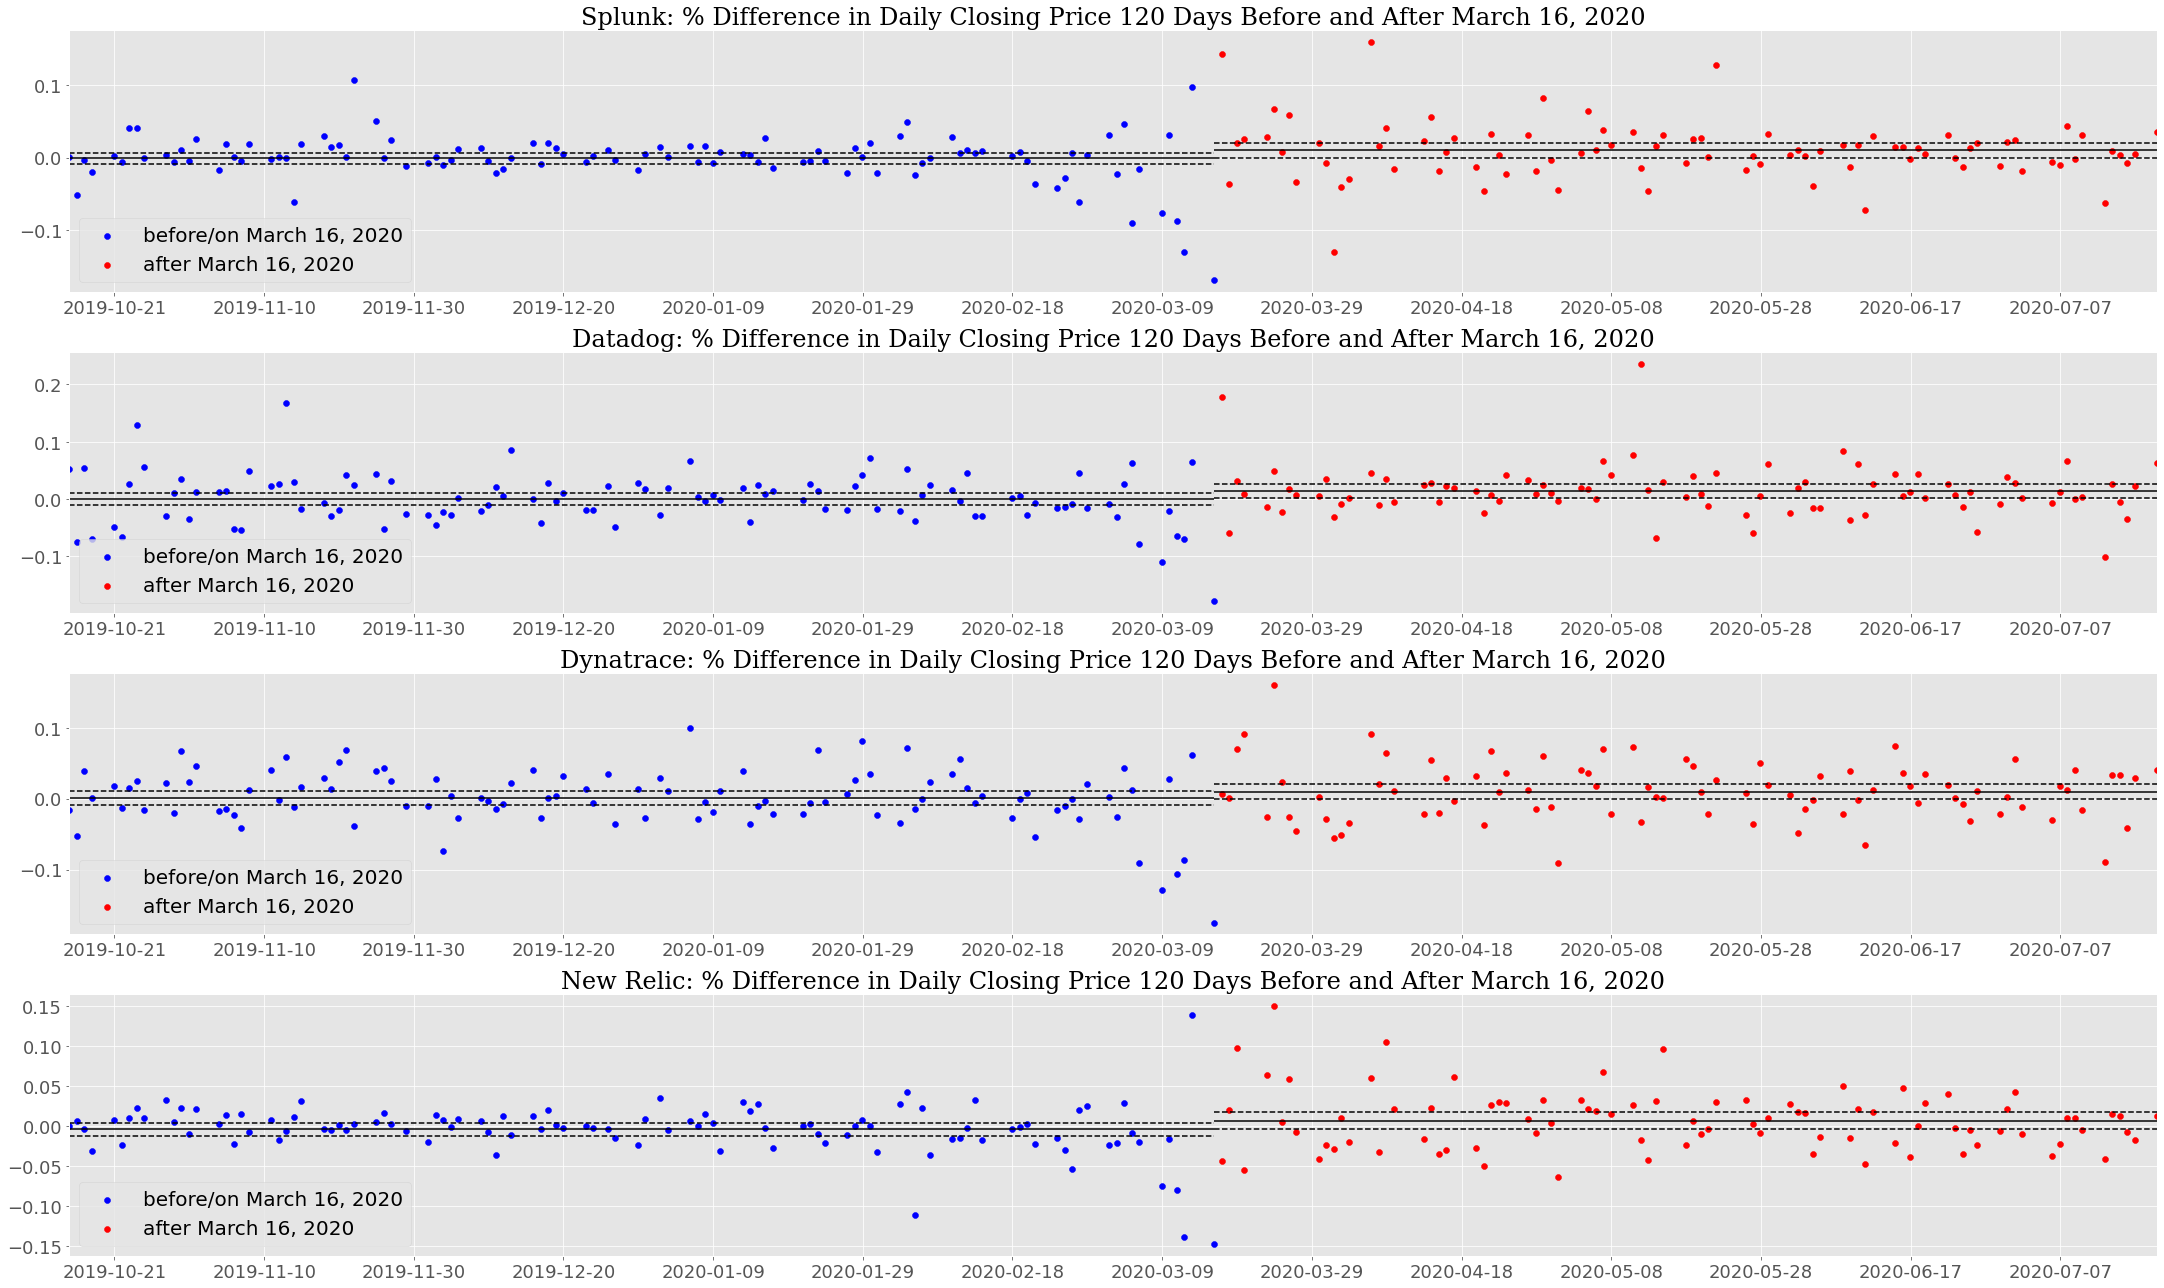

In [12]:
fig, axs = plt.subplots(4, 1, figsize=(30, 18))

for filepath, ax  in zip(filepaths, axs):
    data = data_frame(filepath, reference_date, current_date, moveback_date).before_after
    before, after = data.before, data.after
    ax.scatter(before.index, before["Pct_Diff"], color='b', label='before/on March 16, 2020')
    ax.scatter(after.index, after["Pct_Diff"], color='r', label='after March 16, 2020')
    
    
    before_mean,before_se=statistics(filepaths)[refer[filepath]]['before']['mean'], statistics(filepaths)[refer[filepath]]['before']['se']
    after_mean, after_se=statistics(filepaths)[refer[filepath]]['after']['mean'], statistics(filepaths)[refer[filepath]]['after']['se']
    before_lower, before_upper = confidence_interval(before_mean, before_se, '99%').values()
    after_lower, after_upper = confidence_interval(after_mean, after_se, '99%').values()
    
    plot_hlines(ax, [before_lower, before_mean, before_upper], [data.moveback_date, data.reference_date], ['k', 'k', 'k'], ['dashed', 'solid', 'dashed'])
    plot_hlines(ax, [after_lower, after_mean, after_upper], [data.reference_date, data.current_date], ['k', 'k', 'k'], ['dashed', 'solid', 'dashed'])

    
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 20));
    ax.set_title(refer[filepath] + ': % Difference in Daily Closing Price 120 Days Before and After March 16, 2020', fontdict=font);
    ax.set_xlim((data.moveback_date, data.current_date))
    ax.legend(loc='lower left', prop={'size': 20})
    set_axis_sizes(ax)
    
    
fig.tight_layout();
# plt.savefig('../figures/before_after_diff_distribution.png')

## Plot distributions before and after March 16, 2020

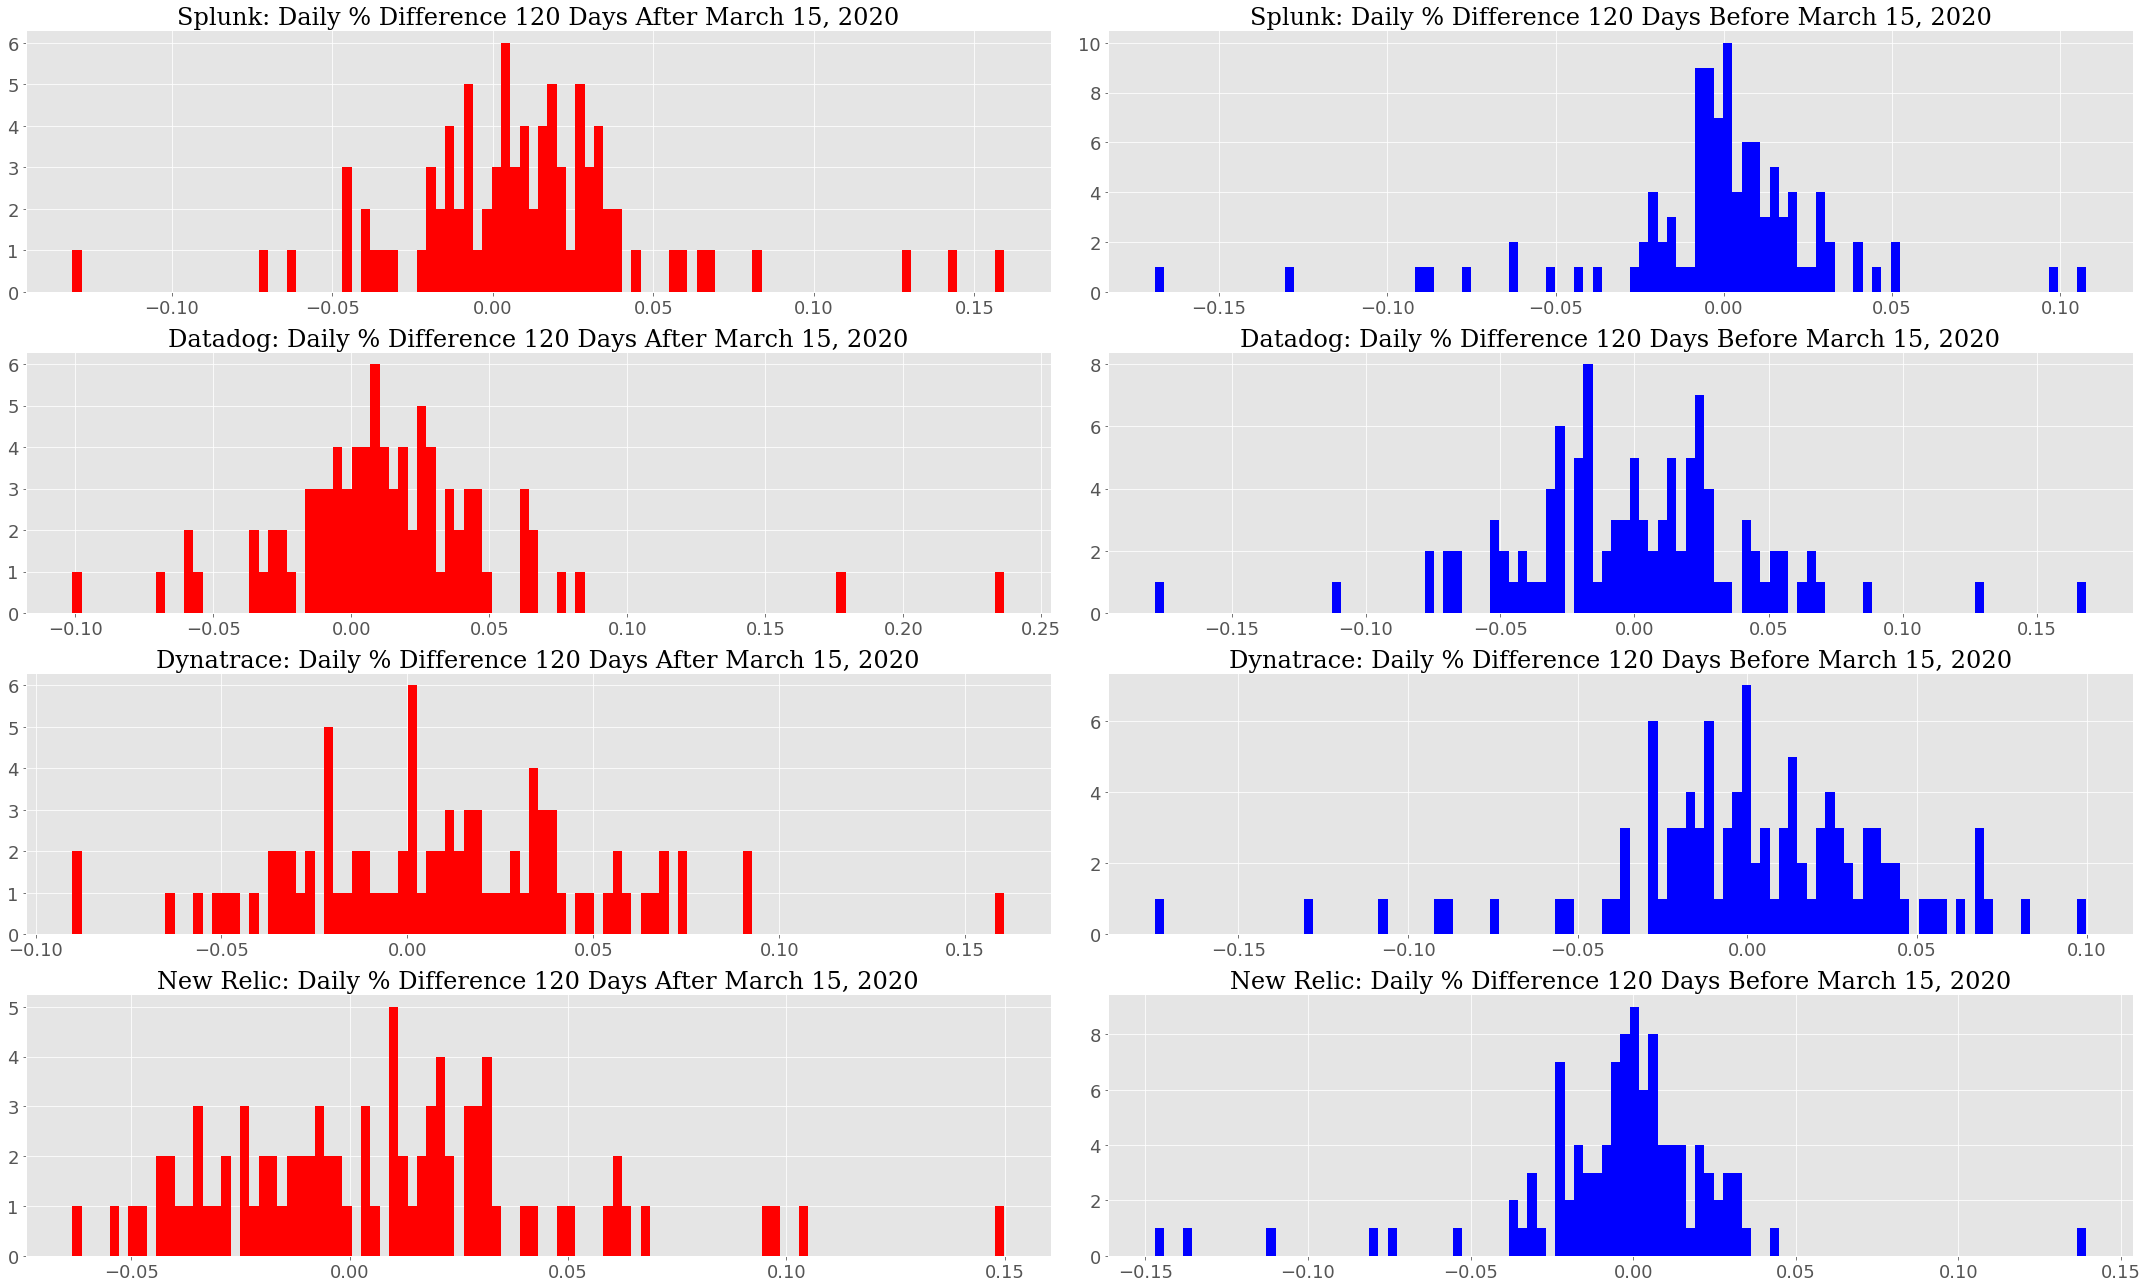

In [13]:
fig, axs = plt.subplots(4, 2, figsize=(30, 18))
plots = axs.flatten()
for filepath, ax  in zip(filepaths, axs):
    data = data_frame(filepath, reference_date, current_date, moveback_date).before_after
    before, after = data.before, data.after
    ax[0].hist(after["Pct_Diff"], bins=100, color='r')
    ax[0].set_title(refer[filepath] + ': Daily % Difference 120 Days After March 15, 2020', fontdict=font)
    ax[1].hist(before["Pct_Diff"], bins=100, color='b')
    ax[1].set_title(refer[filepath] + ': Daily % Difference 120 Days Before March 15, 2020', fontdict=font)
    ax[0].tick_params(axis='x', labelsize=18)
    ax[0].tick_params(axis='y', labelsize=18)
    ax[1].tick_params(axis='x', labelsize=18)
    ax[1].tick_params(axis='y', labelsize=18)
    set_axis_sizes(ax[0])
    set_axis_sizes(ax[1])


fig.tight_layout();
#plt.savefig('../figures/before_after_Histogram_Normalized_Diff.png')

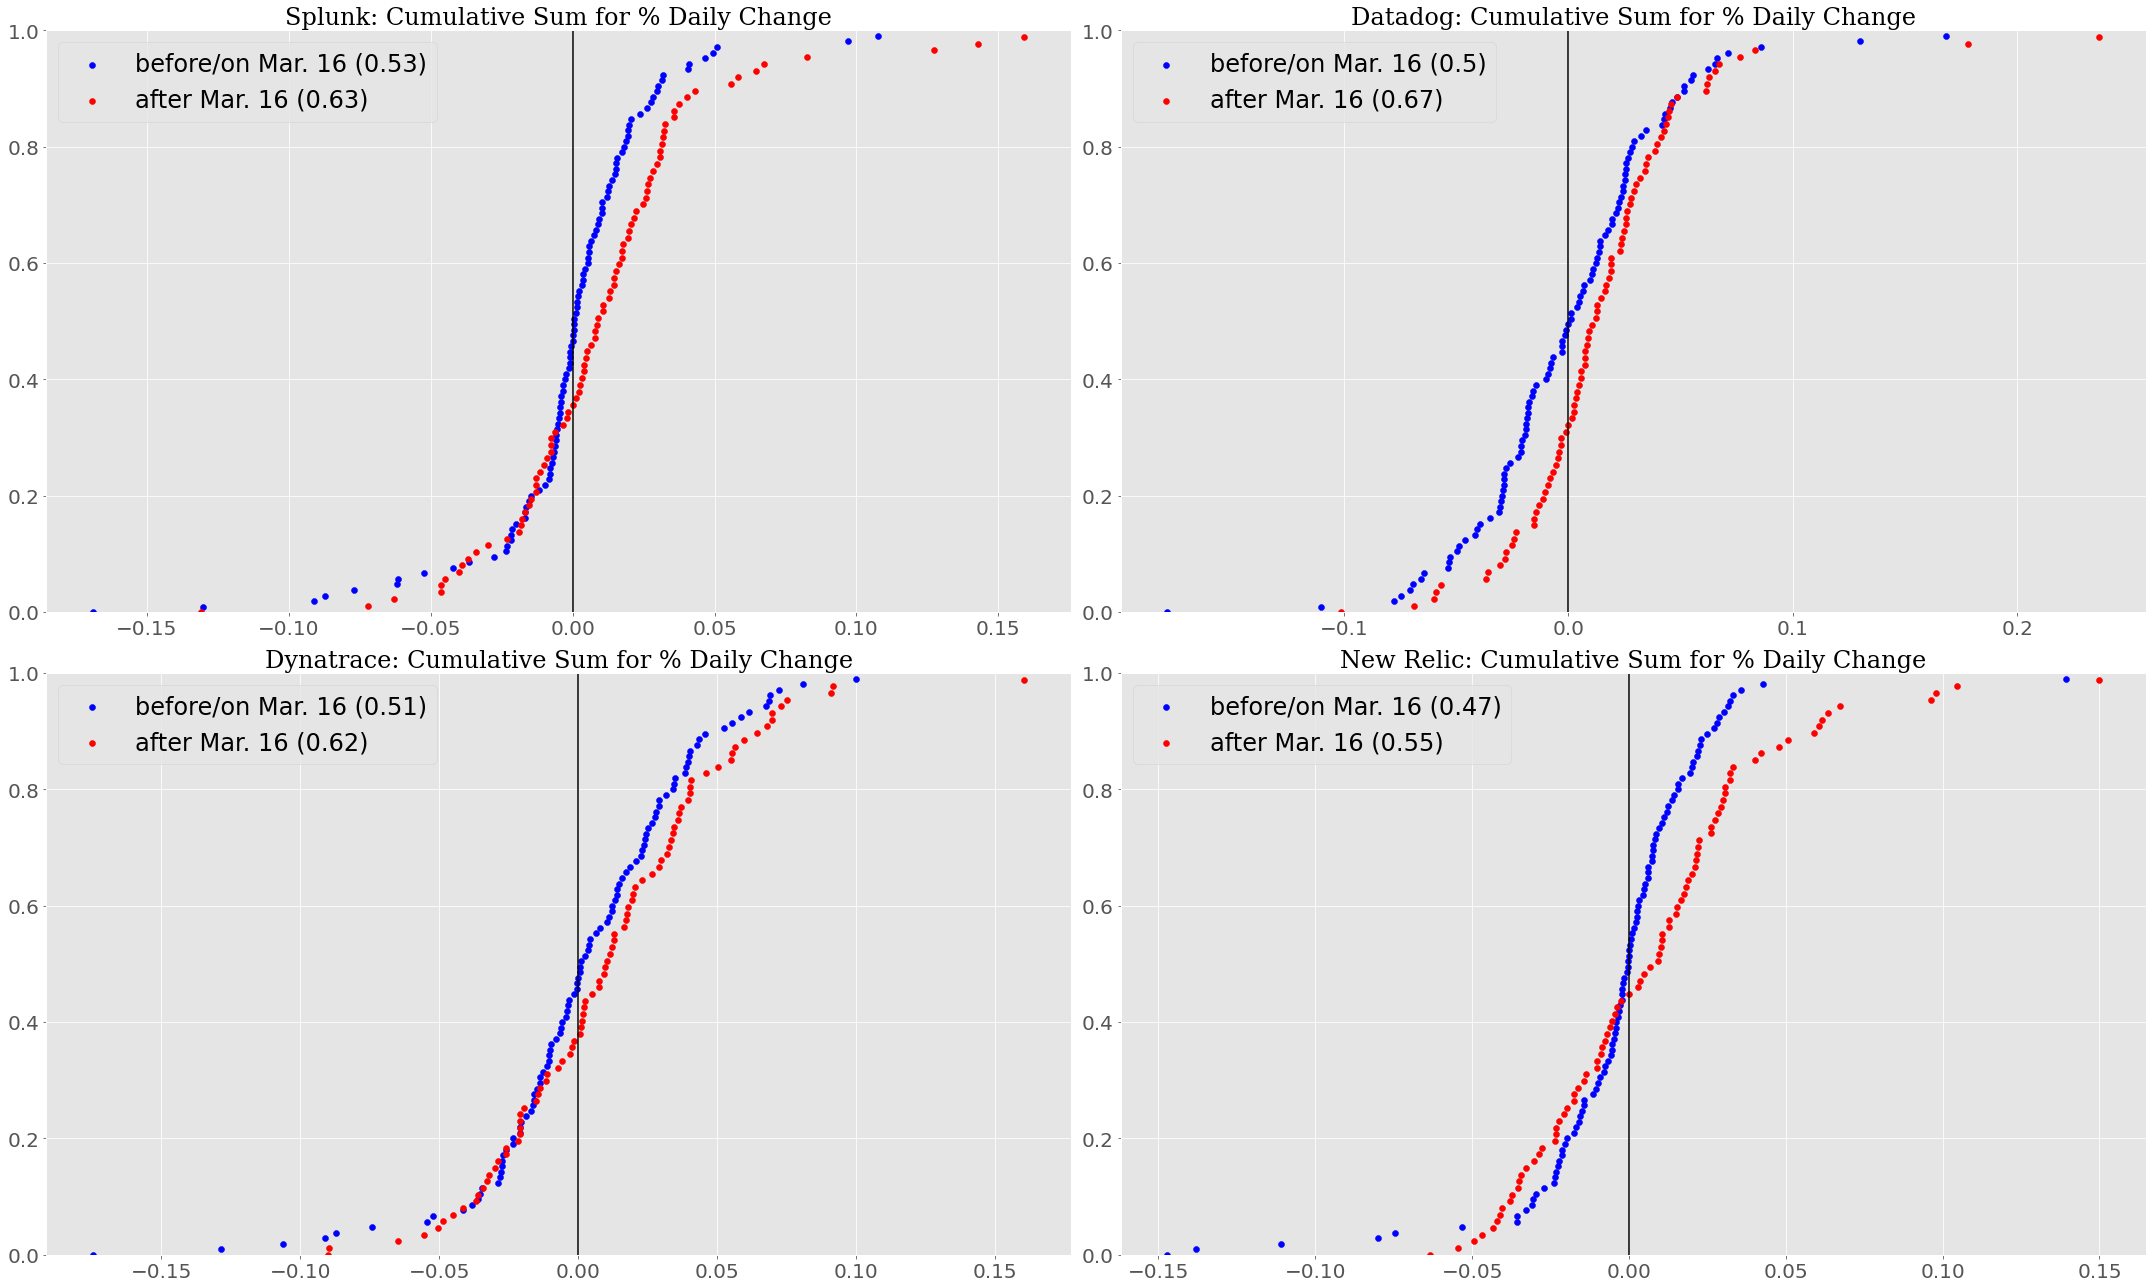

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(30, 18))
plots = axs.flatten()
bayesian_count = dict()
for filepath, ax, c  in zip(filepaths, axs.flatten(), np.arange(8)):
    data = data_frame(filepath, reference_date, current_date, moveback_date).before_after
    before, after = data.before, data.after
    cdf1 = vcdf(value = before["Pct_Diff"], array = before["Pct_Diff"])
    cdf2 = vcdf(value = after["Pct_Diff"], array = after["Pct_Diff"])
    before_count = before[before["Pct_Diff"]>0]['Pct_Diff'].count() / before['Pct_Diff'].count()
    after_count = after[after["Pct_Diff"]>0]['Pct_Diff'].count() / after['Pct_Diff'].count()
    before_count = round(before_count, 2)
    after_count = round(after_count, 2)
    ax.scatter(before["Pct_Diff"], cdf1, label=f'before/on Mar. 16 ({before_count})', color='b')
    ax.scatter(after["Pct_Diff"], cdf2, label=f'after Mar. 16 ({after_count})', color='r')
    ax.set_title(refer[filepath] + ': Cumulative Sum for % Daily Change', fontdict=font)
    ax.vlines(0.0, 0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.legend(loc='best', prop={'size': 24})
    bayesian_count[refer[filepath]] = \
                                    {
                                    'before': {'positive': before_count, 'negative': 1-before_count, 'count': before['Pct_Diff'].count()},
                                    'after' : {'positive': after_count, 'negative': 1-after_count, 'count': after['Pct_Diff'].count()}
                                    }
        
fig.tight_layout();
# fig.savefig('../figures/cumul.png')

In [21]:
data = data_frame('../data/NEWR.csv', reference_date, current_date, moveback_date).before_after
before, after = data.before, data.after
adfuller(after['Pct_Diff'])

(-9.94173917906023,
 2.6532228493611306e-17,
 0,
 86,
 {'1%': -3.5087828609430614,
  '5%': -2.895783561573195,
  '10%': -2.5850381719848565},
 -294.3184012733062)

In [22]:
stationarity_test('../data/GSPC.csv', 'Pct_Diff', reference_date, current_date, moveback_date)

{'before': {'ADF': 0.47950673325471843,
  'p-value': 0.984236728660709,
  '1%': -3.502704609582561,
  '5%': -2.8931578098779522,
  '10%': -2.583636712914788},
 'after': {'ADF': -7.871253723783716,
  'p-value': 4.9781650082343155e-12,
  '1%': -3.5117123057187376,
  '5%': -2.8970475206326833,
  '10%': -2.5857126912469153}}

### Bayesian Test

In [23]:
data = data_frame('../data/GSPC.csv', reference_date, current_date, moveback_date).before_after
before, after = data.before, data.after

In [24]:
bayesian_count

{'Splunk': {'before': {'positive': 0.53, 'negative': 0.47, 'count': 105},
  'after': {'positive': 0.63, 'negative': 0.37, 'count': 87}},
 'Datadog': {'before': {'positive': 0.5, 'negative': 0.5, 'count': 105},
  'after': {'positive': 0.67, 'negative': 0.32999999999999996, 'count': 87}},
 'Dynatrace': {'before': {'positive': 0.51, 'negative': 0.49, 'count': 105},
  'after': {'positive': 0.62, 'negative': 0.38, 'count': 87}},
 'New Relic': {'before': {'positive': 0.47, 'negative': 0.53, 'count': 105},
  'after': {'positive': 0.55, 'negative': 0.44999999999999996, 'count': 87}}}

TypeError: 'function' object is not subscriptable

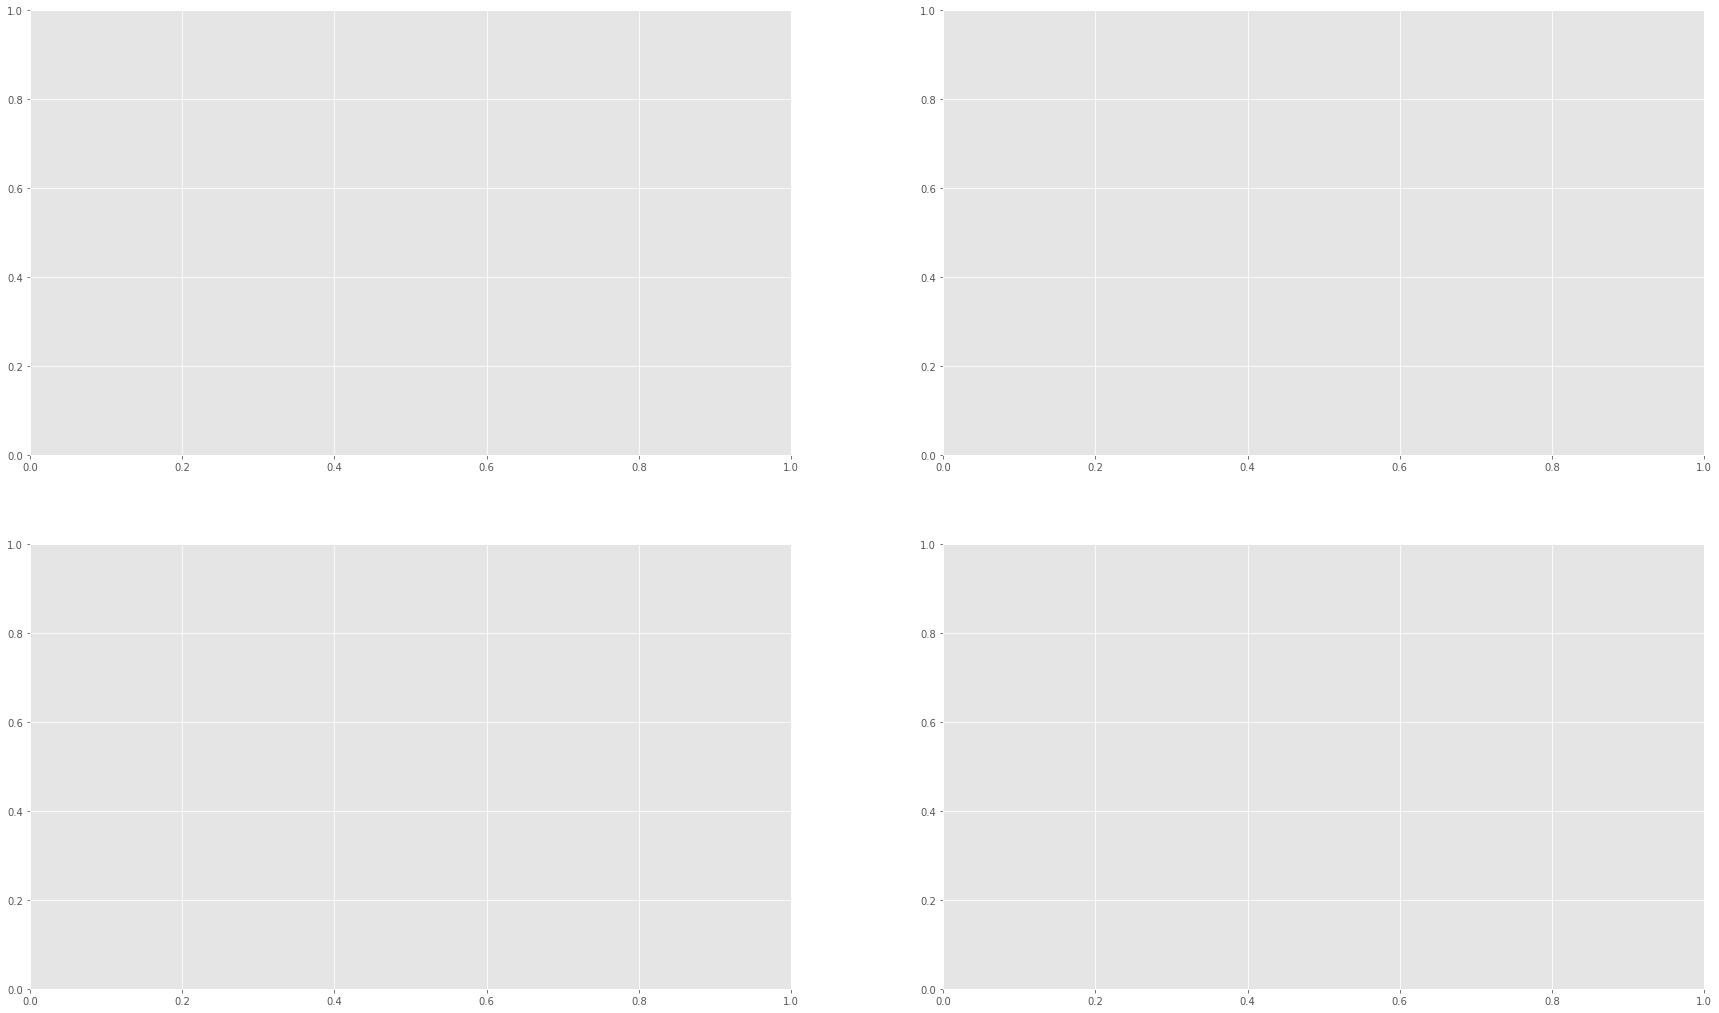

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(30,18))
x = np.arange(0, 1.01, 0.001)
for filepath,ax in zip(filepaths, axs.flatten()):
    col=refer[filepath]
    positive_before, negative_before, count_before = bayesian_count[col]['before']['positive'], bayesian_count[col]['before']['negative'], bayesian_count[col]['before']['count']
    positive_after, negative_after, count_after = bayesian_count[col]['after']['positive'], bayesian_count[col]['after']['negative'], bayesian_count[col]['after']['count']
    plot_with_fill(ax, x, stats.beta(count_before*positive_before, count_before*negative_before).pdf(x), label=f'{col} Before', color='b')
    plot_with_fill(ax, x, stats.beta(count_after*positive_after, count_after*negative_after).pdf(x), label=f'{col} After', color='r')
    set_axis_sizes(ax)
    ax.set_title(f'Bayesian Test for {col} 4 Months before and after March 16', fontdict=font)
    ax.legend(loc='best', prop={'size': 20})
fig.tight_layout(); 
plt.savefig('../figures/bayesian_test.png')

In [77]:
bayesian_count['Splunk']

{'before': {'alpha': 0.53, 'beta': 0.47},
 'after': {'alpha': 0.63, 'beta': 0.37}}

In [78]:
for filepath  in filepaths:
    data = data_frame(filepath, reference_date, current_date, moveback_date).before_after
    before, after = data.before, data.after

In [80]:
before['p'].count()

Date                105
Open                105
High                105
Low                 105
Close               105
Adj Close           105
Volume              105
Noramlized_Close    105
Diff                105
Pct_Diff            105
Normalized_Diff     105
dtype: int64

In [152]:
for filepath in filepaths:
    print(type(refer[filepath]))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


# Plot dynamic evolution with bayes

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(30, 18))
x = np.arange(0, 1.01, 0.001)
bayesian_count = dict()
for filepath, ax  in zip(filepaths, axs.flatten()):
    col=refer[filepath]
    for mov, cur, color in bayes_intervals:
        data = data_frame(filepath, reference_date, cur, mov).chunk.part
        positive_count = data[data["Pct_Diff"]>0]['Pct_Diff'].count() 
        negative_count = data[data["Pct_Diff"]<0]['Pct_Diff'].count()
        plot_with_fill(ax, x, stats.beta(positive_count, negative_count).pdf(x), label=f'Period: ({mov[5:]}-{cur[5:]})', color=color)
    ax.set_title(refer[filepath] + ': Monthly Evolution of Stock Price Post-Covid', fontdict=font)
    set_axis_sizes(ax)
    ax.legend(loc='best', prop={'size': 20})
        
fig.tight_layout(); 
plt.savefig('../figures/monthly_evolution.png')

In [1]:
fig, axs = plt.subplots(2, 2, figsize=(30,15))
x = np.arange(0, 1.01, 0.001)
for filepath,ax in zip(filepaths, axs.flatten()):
    col=refer[filepath]
    positive_before, negative_before, count_before = bayesian_count[col]['before']['positive'], bayesian_count[col]['before']['negative'], bayesian_count[col]['before']['count']
    positive_after, negative_after, count_after = bayesian_count[col]['after']['positive'], bayesian_count[col]['after']['negative'], bayesian_count[col]['after']['count']
    plot_with_fill(ax, x, stats.beta(count_before*alpha_before, count_before*beta_before).pdf(x), label=f'{col} Before')
    plot_with_fill(ax, x, stats.beta(count_after*alpha_after, count_after*beta_after).pdf(x), label=f'{col} After')

    ax.legend()

NameError: name 'plt' is not defined

In [19]:
bayesian_count(filepaths)

TypeError: 'dict' object is not callable

In [263]:
filepaths

['../data/SPLK.csv', '../data/DDOG.csv', '../data/DT.csv', '../data/NEWR.csv']